# Predicting risk of developing depression and anxiety in Spain

## Pasos a seguir:

- Definir manualmente variables interesantes
- Modificar nombres de variables interesantes para no tener el codigo
- Agrupar variables para hacer un analisis exploratorio
- Crear target 
- Terminar de fusionar la target Depresion + Ansiedad

The following project employs data from the Spain's 2020 European Health Survey (EHS). The Spain's EHS aims to provide information about the overall health status of Spain's population regarding cronic diseases or accidents, limitations to complete daily activities, access and use of health care services, as well as environmental characteristics and daily life-habits that may represent a health risk. The **key variables** for this project are **G25a_20** and **G25a_21**, which measure whether the participant has suffered depression or anxiety, respectively.
 
Source: https://www.ine.es/dyngs/INEbase/operacion.htm?c=Estadistica_C&cid=1254736176784&menu=resultados&idp=1254735573175#!tabs-1254736195745

## All imports

In [1]:
#######data management/analysis libraries, and storing models:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3 #for sql tables
from pickle import dump, load #for storing models after tunning
import re
import json #to work with json data format

#######Iterative imputer to fill missing numerical data:
    # explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
    # now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

#######feature selection selectkbest and method
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression, f_classif

#######splitting train and test and model tunning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV

#######model performance assessment
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report, ConfusionMatrixDisplay, confusion_matrix


In [2]:

def ver_dataframe_completo():

    # Configura Pandas para mostrar DataFrames completos sin truncar
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)

def ver_dataframe_columnas():

    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

def restaurar_ajuste():

    # Restaura el valor de pandas para mostrar dataframes truncados
    pd.reset_option('all')
    

In [3]:
ver_dataframe_columnas()

# Preliminary data exploration

Importing data:

In [4]:
#RUTA_DATAFRAME = '/media/tr4shhh/Tr4Shhh_FOLDER/Proyects/4geeks/FINAL_Proyect/EESEadulto_2020.csv'
RUTA_DATAFRAME = '/workspaces/mental_health_spain/data/raw/EESEadulto_2020.csv'

dtypes={'K33': object, 'K35':object}

df = pd.read_csv(RUTA_DATAFRAME, sep='\t', dtype=dtypes)

The data contains:
*   Roughly 22k observations
*   427 variables:
    *   70 are float format
    *   150 are integer format
    *   207 are object format

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22072 entries, 0 to 22071
Columns: 427 entries, CCAA to CUADROS_DEPRESIVOS
dtypes: float64(70), int64(150), object(207)
memory usage: 71.9+ MB


## Recoding empty cells as missing values

Empty cells:

In [6]:
df.head(5)

,CCAA,IDENTHOGAR,A7_2a,SEXOa,EDADa,PROXY_0,PROXY_1,PROXY_2,PROXY_2b,PROXY_3b,PROXY_4,PROXY_5,E1_1,E1C,E1E,E2_1a,E2_1b,E2_1c,E2_1d,E3,E4,E4b,ESTUDIOS,F6,F7,F8_2,F9_2,F10,F11,F12,F13,F14a,F14b,F15,F16,F17,F18a_2,F18b_2,F19a_2,F19b_2,F20,G21,G22,G23,G24,G24a,G25a_1,G25b_1,G25c_1,G25a_2,G25b_2,G25c_2,G25d_2,G25a_3,G25b_3,G25c_3,G25a_4,G25b_4,G25c_4,G25a_5,G25b_5,G25c_5,G25a_6,G25b_6,G25c_6,G25a_7,G25b_7,G25c_7,G25a_8,G25b_8,G25c_8,G25a_9,G25b_9,G25c_9,G25a_10,G25b_10,G25c_10,G25a_11,G25b_11,G25c_11,G25a_12,G25b_12,G25c_12,G25a_13,G25b_13,G25c_13,G25a_14,G25b_14,G25c_14,G25a_15,G25b_15,G25c_15,G25a_16,G25b_16,G25c_16,G25a_17,G25b_17,G25c_17,G25a_18,G25b_18,G25c_18,G25a_19,G25b_19,G25c_19,G25a_20,G25b_20,G25c_20,G25a_21,G25b_21,G25c_21,G25a_22,G25b_22,G25c_22,G25a_23,G25b_23,G25c_23,G25d_23,G25a_24,G25b_24,G25c_24,G25a_25,G25b_25,G25c_25,G25a_26,G25b_26,G25c_26,G25a_27,G25b_27,G25c_27,G25a_28,G25b_28,G25c_28,G25a_29,G25b_29,G25c_29,G25a_30,G25b_30,G25c_30,G25a_31,G25b_31,G25c_31,G25a_32,G25b_32,G25c_32,H26_1,H26_2,H26_3,H27,J30,J31,K32,K33,K34,K35,K36,K37,K38,K38a,K38b,L39_1,L39_2,L39_3,L39_4,L39_5,L40,L41,L42_1,L42_2,L42_3,L42_4,L42_5,L42_6,L42_7,L43,L44,L45,L46,N48,N49,N50,N51,N52,N53,N54,N57,N58_1,N58_2,N58_3,N59,N60_1,N60_2,N60_3,N60_4,N60a_1,N60a_2,N60a_3,N60a_4,N61_1,N61_2,N61_3,N61_4,N61_5,N62,N62b,N63_1,N63_2,N63_3,N63_4,N63_5,N63_6,N63_7,N63_8,N63_9,N63_10,N64,N65_1,N65_2,N65_3,N65_4,N65_5,N65_6,N65_7,N65_8,O66,O67,O68,O69,O71,O74,O75,O76,O78,O79,O80_1,O80_2,O80_3,O81_1,O81_2,O81_3,O82_1,O82_2,O83,O84_1,O84_2,O84_3,O84_4,O84_5,O84_6,O84_7,O84_8,O84_9,P85,P86,P87_1a,P87_1b,P87_2a,P87_2b,P87_3a,P87_3b,P87_4a,P87_4b,P87_5a,P87_5b,P87_6a,P87_6b,P87_7a,P87_7b,P87_8a,P87_8b,P87_9a,P87_9b,P87_10a,P87_10b,P87_11a,P87_11b,P87_12a,P87_12b,P87_13a,P87_13b,P87_14a,P87_14b,P87_15a,P87_15b,P87_16a,P87_16b,P87_17a,P87_17b,P87_18a,P87_18b,P87_19a,P87_19b,P87_20a,P87_20b,P87_21a,P87_21b,P87_22a,P87_22b,P87_23a,P87_23b,Q88,Q89,Q90,Q91,Q92,Q93,Q94,Q95,Q96,Q98,Q99,Q100,Q101,Q103,Q104,R106,R107,R108_1,R108_2,R108_3,R108_4,S109,S110,T111,T112,T113,T114,T115,T116,T117,T118_1,T118_2,T119,T119b_1,T119b_2,U120_1,U120_1a,U120_2,U120_3,U120_4,U120_5,U120_6,U120_7,U120_7a,U120_8,U120_9,U120_10,U120_11,U120_12,U120_13,U120_14,U120_15,U120_15a,U120FZ,U120CANTFZ,V121,V123,V124,V124a,V124b,V126,V126a,V126b,V126c,W127,W128Cer,W128Cer_1,W128Cer_2,W128Cer_3,W128Cer_4,W128Cer_5,W128Cer_6,W128Cer_7,W128Vin,W128Vin_1,W128Vin_2,W128Vin_3,W128Vin_4,W128Vin_5,W128Vin_6,W128Vin_7,W128Vermut,W128Vermut_1,W128Vermut_2,W128Vermut_3,W128Vermut_4,W128Vermut_5,W128Vermut_6,W128Vermut_7,W128Lic,W128Lic_1,W128Lic_2,W128Lic_3,W128Lic_4,W128Lic_5,W128Lic_6,W128Lic_7,W128Comb,W128Comb_1,W128Comb_2,W128Comb_3,W128Comb_4,W128Comb_5,W128Comb_6,W128Comb_7,W128Sidra,W128Sidra_1,W128Sidra_2,W128Sidra_3,W128Sidra_4,W128Sidra_5,W128Sidra_6,W128Sidra_7,W129,X130,X131,X132,Y133,Y134,Y135,FACTORADULTO,CLASE_PR,IMC,CMD1,CMD2,CMD3,SEVERIDAD_DEPRESIVA,CUADROS_DEPRESIVOS
0,16,2500011,1,1,60,1,,,,,NaN,,1,1,1,1,2,2,2,NaN,1,2,7,,,,,,,,02,,,1,1,02,291,,820,,,2,2,3,,2,1,2,1,2,,,,2,,,2,,,2,,,2,,,2,,,2,,,1,2,1,2,,,2,,,2,,,2,,,2,,,2,,,2,,,2,,,2,,,2,,,2,,,2,,,2,,,2,,,,2,,,2,,,2,,,2,,,2,,,1,2,1,2,,,,,,2,,,2,2,2,,2,NaN,1,1,2,1,1,1,1,1,1,1,1,1,1,1,,,1,1,1,1,1,1,1,,,1,1,3,NaN,2,0.0,,,,,2,2,2,2,2,2,2,2,2,2,2,2,2,2,,2,2,1,1.0,1,1,2,2,2,2,2,2,2,2,3,2,1,2,2,2,1,1,2,2,NaN,NaN,,,,2,NaN,2,NaN,,,,NaN,NaN,NaN,NaN,NaN,,1,2,2,2,2,2,2,2,2,2,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,1,2,1,2,1,2,1,1,2,,,,,,2,2,2,2,2,2,175,74,1,2,7,2,0,,0,NaN,NaN,0,8,0,6,NaN,1,2,1,4,1,1,1.0,6,3,1,4,6,6,6,6,NaN,,NaN,3,NaN,NaN,1,10.0,4,,3,,6,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09,4,1,2,2,,,822.756,5,2,0.00,0.0,0.00,1,3
1,16,2500021,1,2,87,1,,,,,NaN,,1,1,1,1,2,2,2,NaN,3,3,6,2,,663,132,1,,,,,,,,,,,,,,4,1,1,1,4,1,1,1,2,,,,2,,,2,,,1,2,2,1,1,1,1,1,1,1,1,1,2,,,2,,,1,1,1,2,,,2,,,1,1,1,2,,,1,2,1,2,,,2,

Recoding empty cells as pandas NA:

In [7]:
df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)

Checking the recoding worked:

In [8]:
df.head(5)

,CCAA,IDENTHOGAR,A7_2a,SEXOa,EDADa,PROXY_0,PROXY_1,PROXY_2,PROXY_2b,PROXY_3b,PROXY_4,PROXY_5,E1_1,E1C,E1E,E2_1a,E2_1b,E2_1c,E2_1d,E3,E4,E4b,ESTUDIOS,F6,F7,F8_2,F9_2,F10,F11,F12,F13,F14a,F14b,F15,F16,F17,F18a_2,F18b_2,F19a_2,F19b_2,F20,G21,G22,G23,G24,G24a,G25a_1,G25b_1,G25c_1,G25a_2,G25b_2,G25c_2,G25d_2,G25a_3,G25b_3,G25c_3,G25a_4,G25b_4,G25c_4,G25a_5,G25b_5,G25c_5,G25a_6,G25b_6,G25c_6,G25a_7,G25b_7,G25c_7,G25a_8,G25b_8,G25c_8,G25a_9,G25b_9,G25c_9,G25a_10,G25b_10,G25c_10,G25a_11,G25b_11,G25c_11,G25a_12,G25b_12,G25c_12,G25a_13,G25b_13,G25c_13,G25a_14,G25b_14,G25c_14,G25a_15,G25b_15,G25c_15,G25a_16,G25b_16,G25c_16,G25a_17,G25b_17,G25c_17,G25a_18,G25b_18,G25c_18,G25a_19,G25b_19,G25c_19,G25a_20,G25b_20,G25c_20,G25a_21,G25b_21,G25c_21,G25a_22,G25b_22,G25c_22,G25a_23,G25b_23,G25c_23,G25d_23,G25a_24,G25b_24,G25c_24,G25a_25,G25b_25,G25c_25,G25a_26,G25b_26,G25c_26,G25a_27,G25b_27,G25c_27,G25a_28,G25b_28,G25c_28,G25a_29,G25b_29,G25c_29,G25a_30,G25b_30,G25c_30,G25a_31,G25b_31,G25c_31,G25a_32,G25b_32,G25c_32,H26_1,H26_2,H26_3,H27,J30,J31,K32,K33,K34,K35,K36,K37,K38,K38a,K38b,L39_1,L39_2,L39_3,L39_4,L39_5,L40,L41,L42_1,L42_2,L42_3,L42_4,L42_5,L42_6,L42_7,L43,L44,L45,L46,N48,N49,N50,N51,N52,N53,N54,N57,N58_1,N58_2,N58_3,N59,N60_1,N60_2,N60_3,N60_4,N60a_1,N60a_2,N60a_3,N60a_4,N61_1,N61_2,N61_3,N61_4,N61_5,N62,N62b,N63_1,N63_2,N63_3,N63_4,N63_5,N63_6,N63_7,N63_8,N63_9,N63_10,N64,N65_1,N65_2,N65_3,N65_4,N65_5,N65_6,N65_7,N65_8,O66,O67,O68,O69,O71,O74,O75,O76,O78,O79,O80_1,O80_2,O80_3,O81_1,O81_2,O81_3,O82_1,O82_2,O83,O84_1,O84_2,O84_3,O84_4,O84_5,O84_6,O84_7,O84_8,O84_9,P85,P86,P87_1a,P87_1b,P87_2a,P87_2b,P87_3a,P87_3b,P87_4a,P87_4b,P87_5a,P87_5b,P87_6a,P87_6b,P87_7a,P87_7b,P87_8a,P87_8b,P87_9a,P87_9b,P87_10a,P87_10b,P87_11a,P87_11b,P87_12a,P87_12b,P87_13a,P87_13b,P87_14a,P87_14b,P87_15a,P87_15b,P87_16a,P87_16b,P87_17a,P87_17b,P87_18a,P87_18b,P87_19a,P87_19b,P87_20a,P87_20b,P87_21a,P87_21b,P87_22a,P87_22b,P87_23a,P87_23b,Q88,Q89,Q90,Q91,Q92,Q93,Q94,Q95,Q96,Q98,Q99,Q100,Q101,Q103,Q104,R106,R107,R108_1,R108_2,R108_3,R108_4,S109,S110,T111,T112,T113,T114,T115,T116,T117,T118_1,T118_2,T119,T119b_1,T119b_2,U120_1,U120_1a,U120_2,U120_3,U120_4,U120_5,U120_6,U120_7,U120_7a,U120_8,U120_9,U120_10,U120_11,U120_12,U120_13,U120_14,U120_15,U120_15a,U120FZ,U120CANTFZ,V121,V123,V124,V124a,V124b,V126,V126a,V126b,V126c,W127,W128Cer,W128Cer_1,W128Cer_2,W128Cer_3,W128Cer_4,W128Cer_5,W128Cer_6,W128Cer_7,W128Vin,W128Vin_1,W128Vin_2,W128Vin_3,W128Vin_4,W128Vin_5,W128Vin_6,W128Vin_7,W128Vermut,W128Vermut_1,W128Vermut_2,W128Vermut_3,W128Vermut_4,W128Vermut_5,W128Vermut_6,W128Vermut_7,W128Lic,W128Lic_1,W128Lic_2,W128Lic_3,W128Lic_4,W128Lic_5,W128Lic_6,W128Lic_7,W128Comb,W128Comb_1,W128Comb_2,W128Comb_3,W128Comb_4,W128Comb_5,W128Comb_6,W128Comb_7,W128Sidra,W128Sidra_1,W128Sidra_2,W128Sidra_3,W128Sidra_4,W128Sidra_5,W128Sidra_6,W128Sidra_7,W129,X130,X131,X132,Y133,Y134,Y135,FACTORADULTO,CLASE_PR,IMC,CMD1,CMD2,CMD3,SEVERIDAD_DEPRESIVA,CUADROS_DEPRESIVOS
0,16,2500011,1,1,60,1,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,1,1,1,1,2,2,2,NaN,1,2,7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,02,<NA>,<NA>,1,1,02,291,<NA>,820,<NA>,<NA>,2,2,3,<NA>,2,1,2,1,2,<NA>,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,1,2,1,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,1,2,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,2,<NA>,<NA>,2,2,2,<NA>,2,NaN,1,1,2,1,1,1,1,1,1,1,1,1,1,1,<NA>,<NA>,1,1,1,1,1,1,1,<NA>,<NA>,1,1,3,NaN,2,0.0,<NA>,<NA>,<NA>,<NA>,2,2,2,2,2,2,2,2,2,2,2,2,2,2,<NA>,2,2,1,1.0,1,1,2,2,2,2,2,2,2,2,3,2,1,2,2,2,1,1,2,2,NaN,NaN,<NA>,<NA>,<NA>,2,NaN,2,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,1,2,2,2,2,2,2,2,2,2,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,

Replacing missing values with '-999999' and converting columns as float:

In [9]:
df = df.fillna(-999999).astype(float)

Now all variables are numerical: integer or float

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22072 entries, 0 to 22071
Columns: 427 entries, CCAA to CUADROS_DEPRESIVOS
dtypes: float64(427)
memory usage: 71.9 MB


Now replacing -999999 as missings:

In [11]:
df.replace(-999999 , np.nan, regex=True, inplace=True)

Checking the conversion went well:

In [12]:
df.head(5)

,CCAA,IDENTHOGAR,A7_2a,SEXOa,EDADa,PROXY_0,PROXY_1,PROXY_2,PROXY_2b,PROXY_3b,PROXY_4,PROXY_5,E1_1,E1C,E1E,E2_1a,E2_1b,E2_1c,E2_1d,E3,E4,E4b,ESTUDIOS,F6,F7,F8_2,F9_2,F10,F11,F12,F13,F14a,F14b,F15,F16,F17,F18a_2,F18b_2,F19a_2,F19b_2,F20,G21,G22,G23,G24,G24a,G25a_1,G25b_1,G25c_1,G25a_2,G25b_2,G25c_2,G25d_2,G25a_3,G25b_3,G25c_3,G25a_4,G25b_4,G25c_4,G25a_5,G25b_5,G25c_5,G25a_6,G25b_6,G25c_6,G25a_7,G25b_7,G25c_7,G25a_8,G25b_8,G25c_8,G25a_9,G25b_9,G25c_9,G25a_10,G25b_10,G25c_10,G25a_11,G25b_11,G25c_11,G25a_12,G25b_12,G25c_12,G25a_13,G25b_13,G25c_13,G25a_14,G25b_14,G25c_14,G25a_15,G25b_15,G25c_15,G25a_16,G25b_16,G25c_16,G25a_17,G25b_17,G25c_17,G25a_18,G25b_18,G25c_18,G25a_19,G25b_19,G25c_19,G25a_20,G25b_20,G25c_20,G25a_21,G25b_21,G25c_21,G25a_22,G25b_22,G25c_22,G25a_23,G25b_23,G25c_23,G25d_23,G25a_24,G25b_24,G25c_24,G25a_25,G25b_25,G25c_25,G25a_26,G25b_26,G25c_26,G25a_27,G25b_27,G25c_27,G25a_28,G25b_28,G25c_28,G25a_29,G25b_29,G25c_29,G25a_30,G25b_30,G25c_30,G25a_31,G25b_31,G25c_31,G25a_32,G25b_32,G25c_32,H26_1,H26_2,H26_3,H27,J30,J31,K32,K33,K34,K35,K36,K37,K38,K38a,K38b,L39_1,L39_2,L39_3,L39_4,L39_5,L40,L41,L42_1,L42_2,L42_3,L42_4,L42_5,L42_6,L42_7,L43,L44,L45,L46,N48,N49,N50,N51,N52,N53,N54,N57,N58_1,N58_2,N58_3,N59,N60_1,N60_2,N60_3,N60_4,N60a_1,N60a_2,N60a_3,N60a_4,N61_1,N61_2,N61_3,N61_4,N61_5,N62,N62b,N63_1,N63_2,N63_3,N63_4,N63_5,N63_6,N63_7,N63_8,N63_9,N63_10,N64,N65_1,N65_2,N65_3,N65_4,N65_5,N65_6,N65_7,N65_8,O66,O67,O68,O69,O71,O74,O75,O76,O78,O79,O80_1,O80_2,O80_3,O81_1,O81_2,O81_3,O82_1,O82_2,O83,O84_1,O84_2,O84_3,O84_4,O84_5,O84_6,O84_7,O84_8,O84_9,P85,P86,P87_1a,P87_1b,P87_2a,P87_2b,P87_3a,P87_3b,P87_4a,P87_4b,P87_5a,P87_5b,P87_6a,P87_6b,P87_7a,P87_7b,P87_8a,P87_8b,P87_9a,P87_9b,P87_10a,P87_10b,P87_11a,P87_11b,P87_12a,P87_12b,P87_13a,P87_13b,P87_14a,P87_14b,P87_15a,P87_15b,P87_16a,P87_16b,P87_17a,P87_17b,P87_18a,P87_18b,P87_19a,P87_19b,P87_20a,P87_20b,P87_21a,P87_21b,P87_22a,P87_22b,P87_23a,P87_23b,Q88,Q89,Q90,Q91,Q92,Q93,Q94,Q95,Q96,Q98,Q99,Q100,Q101,Q103,Q104,R106,R107,R108_1,R108_2,R108_3,R108_4,S109,S110,T111,T112,T113,T114,T115,T116,T117,T118_1,T118_2,T119,T119b_1,T119b_2,U120_1,U120_1a,U120_2,U120_3,U120_4,U120_5,U120_6,U120_7,U120_7a,U120_8,U120_9,U120_10,U120_11,U120_12,U120_13,U120_14,U120_15,U120_15a,U120FZ,U120CANTFZ,V121,V123,V124,V124a,V124b,V126,V126a,V126b,V126c,W127,W128Cer,W128Cer_1,W128Cer_2,W128Cer_3,W128Cer_4,W128Cer_5,W128Cer_6,W128Cer_7,W128Vin,W128Vin_1,W128Vin_2,W128Vin_3,W128Vin_4,W128Vin_5,W128Vin_6,W128Vin_7,W128Vermut,W128Vermut_1,W128Vermut_2,W128Vermut_3,W128Vermut_4,W128Vermut_5,W128Vermut_6,W128Vermut_7,W128Lic,W128Lic_1,W128Lic_2,W128Lic_3,W128Lic_4,W128Lic_5,W128Lic_6,W128Lic_7,W128Comb,W128Comb_1,W128Comb_2,W128Comb_3,W128Comb_4,W128Comb_5,W128Comb_6,W128Comb_7,W128Sidra,W128Sidra_1,W128Sidra_2,W128Sidra_3,W128Sidra_4,W128Sidra_5,W128Sidra_6,W128Sidra_7,W129,X130,X131,X132,Y133,Y134,Y135,FACTORADULTO,CLASE_PR,IMC,CMD1,CMD2,CMD3,SEVERIDAD_DEPRESIVA,CUADROS_DEPRESIVOS
0,16.0,2500011.0,1.0,1.0,60.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,2.0,2.0,NaN,1.0,2.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,1.0,2.0,291.0,NaN,820.0,NaN,NaN,2.0,2.0,3.0,NaN,2.0,1.0,2.0,1.0,2.0,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,2.0,1.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,2.0,2.0,NaN,2.0,NaN,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,3.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,Na

## Exploring the variables of interest: anxiety and depression:

The variables of interest, **G25a_20 and G25a_21**, for this project are whether the survey participant has suffered depression or anxiety, respectively.  

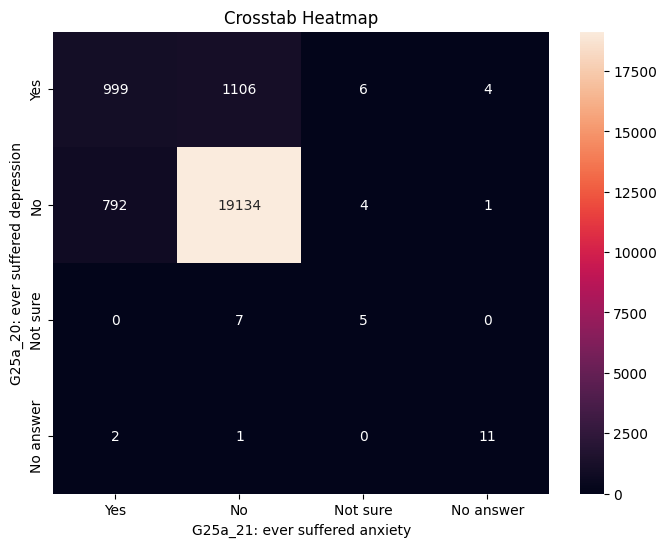

In [13]:
crosstab_result= pd.crosstab(df.G25a_20, df.G25a_21)
plt.figure(figsize=(8, 6))
heatmap=sns.heatmap(crosstab_result, annot=True, fmt='d', cbar=True)
heatmap.set_xticklabels(['Yes', 'No', 'Not sure', 'No answer'])  
heatmap.set_yticklabels(['Yes', 'No', 'Not sure', 'No answer'])  
heatmap.set_ylabel('G25a_20: ever suffered depression')
heatmap.set_xlabel('G25a_21: ever suffered anxiety')
plt.title('Crosstab Heatmap')
plt.show()

**Creating the dependent variable:**

In [14]:
df['dep_anx']=df.G25a_20
df.loc[(df.G25a_21==1) & (df.G25a_20!=1), 'dep_anx']=1
df['dep_anx'] = (df['dep_anx'] == 1).astype(int)


The dependent variable now contrains ~2,900 reported cases of anxiety or depression:

In [15]:
df['dep_anx'].value_counts()

dep_anx
0    19163
1     2909
Name: count, dtype: int64

## Deleting unnecessary variables

For the following project we will exclude ID individual variables as they  do not add predictive power. We also exclude some specific alcohol comsuption variables as they relate to the type of alcohol the survey participant consumes (wine, cider, beer, etc) and which day of the week, and it does not relate to the frequency of comsumption. We have other variables in the dataset that better capture the frequency and quantity of alcohol compsuption. Hence, we delete the aforementioned. We also delete the quantity of fruit and vegeteblas consumed as we have additional variables that better measure frequency comsumption of these types of food and they are comparable with other variables in the dataset such as the frequency of comsumption of high-sugar and fast food.

Finally, we delete the number of hours dedicated to take care of a sick family member per week since most people in the data do not have someone in charge of them. Instead, we keep a variable that captures whether or not the survey participant takes care of a sick relative.  

In [16]:
# Creating a copy of original df to modify it
df_new=df.copy()

List of variables to delete:

In [17]:
to_delete=['IDENTHOGAR',	'A7_2a',	'PROXY_0',	'PROXY_1',	'PROXY_2',	'PROXY_2b',	'PROXY_3b',	'PROXY_4',	'PROXY_5',	 "F7",  "F8_2",  "F9_2",   "F10",  "F11",   "F12",   "F14a",   "F14b",   "N52", "N53",  "N54",  "N57",  "N61_3",'U120_1a',	'U120_7a',	'U120_15a',	'U120CANTFZ',	'W128Cer',	'W128Cer_1',	'W128Cer_2',	'W128Cer_3',	'W128Cer_4',	'W128Cer_5',	'W128Cer_6',	'W128Cer_7',	'W128Vin',	'W128Vin_1',	'W128Vin_2',	'W128Vin_3',	'W128Vin_4',	'W128Vin_5',	'W128Vin_6',	'W128Vin_7',	'W128Vermut',	'W128Vermut_1',	'W128Vermut_2',	'W128Vermut_3',	'W128Vermut_4',	'W128Vermut_5',	'W128Vermut_6',	'W128Vermut_7',	'W128Lic',	'W128Lic_1',	'W128Lic_2',	'W128Lic_3',	'W128Lic_4',	'W128Lic_5',	'W128Lic_6',	'W128Lic_7',	'W128Comb',	'W128Comb_1',	'W128Comb_2',	'W128Comb_3',	'W128Comb_4',	'W128Comb_5',	'W128Comb_6',	'W128Comb_7',	'W128Sidra',	'W128Sidra_1',	'W128Sidra_2',	'W128Sidra_3',	'W128Sidra_4',	'W128Sidra_5', 'W128Sidra_6',	'W128Sidra_7',	'Y134',	'Y135',	'FACTORADULTO',	'CMD1',	'CMD2',	'CMD3']

df_new.drop(to_delete, inplace=True, axis=1)

The new data frame contains 79 less columns as compared to the original:

In [18]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22072 entries, 0 to 22071
Columns: 348 entries, CCAA to dep_anx
dtypes: float64(347), int64(1)
memory usage: 58.6 MB


## Data Transformation 

Next, we convert variables with answer options yes/no to binary variables so that 1: Yes and 0: otherwise

This function transforms the list of variable to binarize into a python list:

In [5]:
def texto_a_lista(texto):
    lista_resultado = texto.split('\t')
    lista_resultado = [item.strip() for item in lista_resultado if item]
    return lista_resultado

In [8]:
def texto_a_lista_2(texto):
    lista_resultado = texto.split('\n')
    lista_resultado = [item.strip() for item in lista_resultado if item]
    return lista_resultado

variables a eliminar 

In [6]:
medicas = '''
G25b_1
G25b_2
G25b_3
G25b_4
G25b_5
G25b_6
G25b_7
G25b_8
G25b_9
G25b_10
G25b_11
G25b_12
G25b_13
G25b_14
G25b_15
G25b_16
G25b_17
G25b_18
G25b_19
G25b_20
G25b_21
G25b_22
G25b_23
G25b_24
G25b_25
G25b_26
G25b_27
G25b_28
G25b_29
G25b_30
G25b_31
G25b_32
G25c_1
G25c_2
G25c_3
G25c_4
G25c_5
G25c_6
G25c_7
G25c_8
G25c_9
G25c_10
G25c_11
G25c_12
G25c_13
G25c_14
G25c_15
G25c_16
G25c_17
G25c_18
G25c_19
G25c_20
G25c_21
G25c_22
G25c_23
G25c_24
G25c_25
G25c_26
G25c_27
G25c_28
G25c_29
G25c_30
G25c_31
G25c_32


'''

In [11]:
preescrip = '''
P87_1a
P87_1b
P87_2a
P87_2b
P87_3a
P87_3b
P87_4a
P87_4b
P87_5a
P87_5b
P87_6a
P87_6b
P87_7a
P87_7b
P87_8a
P87_8b
P87_9a
P87_9b
P87_10a
P87_10b
P87_11a
P87_11b
P87_12a
P87_12b
P87_13a
P87_13b
P87_14a
P87_14b
P87_15a
P87_15b
P87_16a
P87_16b
P87_17a
P87_17b
P87_18a
P87_18b
P87_19a
P87_19b
P87_20a
P87_20b
P87_21a
P87_21b
P87_22a
P87_22b
P87_23a
P87_23b
'''

In [12]:
lista_preescrip = texto_a_lista_2(preescrip)
lista_preescrip

['P87_1a',
 'P87_1b',
 'P87_2a',
 'P87_2b',
 'P87_3a',
 'P87_3b',
 'P87_4a',
 'P87_4b',
 'P87_5a',
 'P87_5b',
 'P87_6a',
 'P87_6b',
 'P87_7a',
 'P87_7b',
 'P87_8a',
 'P87_8b',
 'P87_9a',
 'P87_9b',
 'P87_10a',
 'P87_10b',
 'P87_11a',
 'P87_11b',
 'P87_12a',
 'P87_12b',
 'P87_13a',
 'P87_13b',
 'P87_14a',
 'P87_14b',
 'P87_15a',
 'P87_15b',
 'P87_16a',
 'P87_16b',
 'P87_17a',
 'P87_17b',
 'P87_18a',
 'P87_18b',
 'P87_19a',
 'P87_19b',
 'P87_20a',
 'P87_20b',
 'P87_21a',
 'P87_21b',
 'P87_22a',
 'P87_22b',
 'P87_23a',
 'P87_23b']

In [9]:
lista_medicas = texto_a_lista_2(medicas)
lista_medicas

['G25b_1',
 'G25b_2',
 'G25b_3',
 'G25b_4',
 'G25b_5',
 'G25b_6',
 'G25b_7',
 'G25b_8',
 'G25b_9',
 'G25b_10',
 'G25b_11',
 'G25b_12',
 'G25b_13',
 'G25b_14',
 'G25b_15',
 'G25b_16',
 'G25b_17',
 'G25b_18',
 'G25b_19',
 'G25b_20',
 'G25b_21',
 'G25b_22',
 'G25b_23',
 'G25b_24',
 'G25b_25',
 'G25b_26',
 'G25b_27',
 'G25b_28',
 'G25b_29',
 'G25b_30',
 'G25b_31',
 'G25b_32',
 'G25c_1',
 'G25c_2',
 'G25c_3',
 'G25c_4',
 'G25c_5',
 'G25c_6',
 'G25c_7',
 'G25c_8',
 'G25c_9',
 'G25c_10',
 'G25c_11',
 'G25c_12',
 'G25c_13',
 'G25c_14',
 'G25c_15',
 'G25c_16',
 'G25c_17',
 'G25c_18',
 'G25c_19',
 'G25c_20',
 'G25c_21',
 'G25c_22',
 'G25c_23',
 'G25c_24',
 'G25c_25',
 'G25c_26',
 'G25c_27',
 'G25c_28',
 'G25c_29',
 'G25c_30',
 'G25c_31',
 'G25c_32']

Variables to convert into dummy/binary:

In [26]:
my_vars='''G25a_1	G25b_1	G25c_1	G25a_2	G25b_2	G25c_2	G25d_2	G25a_3	G25b_3	G25c_3	G25a_4	G25b_4	G25c_4	G25a_5	G25b_5	G25c_5	G25a_6	G25b_6	G25c_6	G25a_7	G25b_7	G25c_7	G25a_8	G25b_8	G25c_8	G25a_9	G25b_9	G25c_9	G25a_10	G25b_10	G25c_10	G25a_11	G25b_11	G25c_11	G25a_12	G25b_12	G25c_12	G25a_13	G25b_13	G25c_13	G25a_14	G25b_14	G25c_14	G25a_15	G25b_15	G25c_15	G25a_16	G25b_16	G25c_16	G25a_17	G25b_17	G25c_17	G25a_18	G25b_18	G25c_18	G25a_19	G25b_19	G25c_19	G25a_22	G25b_22	G25c_22	G25a_23	G25b_23	G25c_23	G25d_23	G25a_24	G25b_24	G25c_24	G25a_25	G25b_25	G25c_25	G25a_26	G25b_26	G25c_26	G25a_27	G25b_27	G25c_27	G25a_28	G25b_28	G25c_28	G25a_29	G25b_29	G25c_29	G25a_30	G25b_30	G25c_30	G25a_31	G25b_31	G25c_31	G25a_32	G25b_32	G25c_32	H26_1	H26_2	H26_3	J30	N58_1	N58_2	N58_3	N59	N60_1	N60_2	N60_3	N60_4	N60a_1	N60a_2	N60a_3	N60a_4	N61_1	N61_2	N61_4	N61_5	N63_1	N63_2	N63_3	N63_4	N63_5	N63_6	N63_7	N63_8	N63_9	N63_10	N65_1	N65_2	N65_3	N65_4	N65_5	N65_6	N65_7	N65_8	O66	O69	O75	O78	O80_1	O80_2	O80_3	O84_1	O84_2	O84_3	O84_4	O84_5	O84_6	O84_7	O84_8	O84_9	P85	P86	P87_1a	P87_1b	P87_2a	P87_2b	P87_3a	P87_3b	P87_4a	P87_4b	P87_5a	P87_5b	P87_6a	P87_6b	P87_7a	P87_7b	P87_8a	P87_8b	P87_9a	P87_9b	P87_10a	P87_10b	P87_11a	P87_11b	P87_12a	P87_12b	P87_13a	P87_13b	P87_14a	P87_14b	P87_15a	P87_15b	P87_16a	P87_16b	P87_17a	P87_17b	P87_18a	P87_18b	P87_19a	P87_19b	P87_20a	P87_20b	P87_21a	P87_21b	P87_22a	P87_22b	P87_23a	P87_23b	Q88	Q89	Q91	Q93	Q95	Q98	Q100	Q103	R106	R107	R108_1	R108_2	R108_3	R108_4	U120FZ	V124a	Y133'''


Coverting into a python list:

In [27]:
to_binary = texto_a_lista(my_vars)

Function to binarize all variables in the list:

In [29]:
def binarize(dataframe, target):
    dataframe[target] = dataframe[target].applymap(lambda x: 1 if x == 1 else 0)
    return dataframe

In [30]:
df_final = binarize(df_new, to_binary)

/tmp/ipykernel_5966/1899101253.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataframe[target] = dataframe[target].applymap(lambda x: 1 if x == 1 else 0)


In [31]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22072 entries, 0 to 22071
Columns: 348 entries, CCAA to dep_anx
dtypes: float64(136), int64(212)
memory usage: 58.6 MB


Storing modified dataframe with dummy variables:

In [32]:
df_final.to_csv('../data/interim/df_final.csv', index=False )